In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns',500)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB


from sklearn.metrics import mean_squared_error,accuracy_score, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest, f_regression,mutual_info_regression
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, KFold

In [4]:
df_norm = pd.read_csv('data/pbp_data_mvp.csv')
df_norm.drop(columns='Unnamed: 0',inplace=True)

In [5]:
df_norm.target.value_counts()

 1    25777
 0    22787
-1        4
Name: target, dtype: int64

# Base Modeling

In [61]:
def baseline_prediction(X,y):
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=99)

    # Scaling is Needed for Knn
    scaler = StandardScaler()  
    scaler.fit(X_train)

    X_train_scaled = scaler.transform(X_train)  
    X_test_scaled = scaler.transform(X_test)

    # Logistic Regression
    lr_base = LogisticRegression(random_state=99)
    lr_base.fit(X_train,y_train)
    pred_lr_base = lr_base.predict(X_train)
    score_lr_base = accuracy_score(y_train,pred_lr_base)
    print('Logistic Regression Accuracy: {}'.format(score_lr_base))

    pred_lr_base_test = lr_base.predict(X_test)
    score_lr_base_test = accuracy_score(y_test,pred_lr_base_test)
    print('Logistic Regression Test Accuracy: {}'.format(score_lr_base_test))
    
#     # KNN
#     knn_base = KNeighborsClassifier()
#     knn_base.fit(X_train_scaled,y_train)
#     pred_knn_base = knn_base.predict(X_train_scaled)
#     score_knn_base = accuracy_score(y_train,pred_knn_base)
#     print('KNN Accuracy: {}'.format(score_knn_base))

#     pred_knn_base_test = knn_base.predict(X_test_scaled)
#     score_knn_base_test = accuracy_score(y_test,pred_knn_base_test)
#     print('KNN Test Accuracy: {}'.format(score_knn_base_test))
    
    # Decision Tree
    tree_base = DecisionTreeClassifier(max_depth=15)
    tree_base.fit(X_train,y_train)
    pred_tree_base = tree_base.predict(X_train)
    score_tree_base = accuracy_score(y_train,pred_tree_base)
    print('Tree Accuracy: {}'.format(score_tree_base))

    pred_tree_base_test = tree_base.predict(X_test)
    score_tree_base_test = accuracy_score(y_test,pred_tree_base_test)
    print('Tree Test Accuracy: {}'.format(score_tree_base_test))
    
    # Random Forest
    rand_base = RandomForestClassifier()
    rand_base.fit(X_train,y_train)
    pred_rand_base = rand_base.predict(X_train)
    score_rand_base = accuracy_score(y_train,pred_rand_base)
    print('Random Forest Accuracy: {}'.format(score_rand_base))

    pred_rand_base_test = rand_base.predict(X_test)
    score_rand_base_test = accuracy_score(y_test,pred_rand_base_test)
    print('Random Forest Test Accuracy: {}'.format(score_rand_base_test))
    
    #XG Boost
    xg_base = xgb.XGBClassifier(objecteve='binary:logistic')
    xg_base.fit(X_train,y_train)
    pred_xg_base = xg_base.predict(X_train)
    score_xg_base = accuracy_score(y_train,pred_xg_base)
    print('XGBoost Accuracy: {}'.format(score_xg_base))

    pred_xg_base_test = xg_base.predict(X_test)
    score_xg_base_test = accuracy_score(y_test,pred_xg_base_test)
    print('XGBoost Test Accuracy: {}'.format(score_xg_base_test))

## Normal Data (game per game stats)

#### Dropping non-numeric columns

In [ ]:
cols_to_drop = ['forfeit_info','lf_ump_id','rf_ump_id','protest_info',
                'date_game_completed','additional_info','save_pitch_id',
                'game_win_rbi_batter_id','game_in_series','away_catch_interference',
                'home_catch_interference','away_pitch_balks',
                'home_pitch_balks','day_of_week','away_league',
                'away_team_game_number','home_league',
                'home_team_game_number','day_or_night','park_id',
                'attendance','time_of_game','away_line_scores',
                'home_line_scores','year','id','outcome',
               'Date','away_team','home_team']
df_norm.drop(columns=cols_to_drop,inplace=True)
df_norm.drop(df_norm.loc[:,'hb_ump_id':'acquisition_info'],axis=1,inplace=True)

In [ ]:
df_norm.replace([np.inf,-np.inf],np.nan,inplace=True)

In [ ]:
df_norm.dropna(inplace=True)

In [ ]:
X_norm = df_norm.drop(columns='target')
y_norm = df_norm.target

#### Baseline

In [ ]:
baseline_prediction(X_norm,y_norm)

# In Depth Modeling

## Logistic Regression Grid Search

In [ ]:
X_train_agg_cutt_selected, X_test_agg_cutt_selected, y_train_agg_cutt_selected, y_test_agg_cutt_selected = train_test_split(X_agg_cutt[selected_wrapper],y_agg_cutt,random_state=99)

In [ ]:
param_grid_lr = { 
    'penalty': ['l2','l1','elasticnet'],
    'C': [1e9,100,1,0.1,0.05,],
    'max_iter':[100,500,1000]
}

grid_lr=GridSearchCV(LogisticRegression(),
                         param_grid_lr, 
                         cv=10, 
                         scoring='accuracy', 
                         verbose=1, 
                         n_jobs=-1)

grid_lr.fit(X_train_agg_cutt_selected,y_train_agg_cutt_selected)

# Single best score achieved across all params (min_samples_split)
print(grid_lr.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_lr.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_lr.best_estimator_)

In [ ]:
#Predict the response for test dataset
y_pred_test = grid_lr.best_estimator_.predict(X_test_agg_cutt_selected)

y_pred_train = grid_lr.best_estimator_.predict(X_train_agg_cutt_selected)


train_acc = accuracy_score(y_train_agg_cutt_selected, y_pred_train)
test_acc = accuracy_score(y_test_agg_cutt_selected, y_pred_test)

print("Train Accuracy: %f" % (train_acc))
print("Test Accuracy: %f" % (test_acc))


## XG Boost Grid Search

Going to use XG boost for now as it perfomed the best out of all combinations. This will be using the aggregated data.

In [ ]:
X_train_agg, X_test, y_train_agg, y_test = train_test_split(X_agg,y_agg,random_state=99)

In [ ]:
clf_xgb = xgb.XGBClassifier(objective = 'binary:logistic')
param_dist = {'n_estimators': [100,300,500],
              'learning_rate': [1,0.1,0.05,0.01],
              'max_depth': [3, 5, 7, 10],
              'colsample_bytree': [0.5,0.45,0.4],
              'min_child_weight': [1, 2, 3]
             }
gsearch1 = GridSearchCV(
    estimator = clf_xgb,
    param_grid = param_dist, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    iid=False, 
    cv=5)

In [ ]:
gsearch1.fit(X_train,y_train)

In [ ]:
gsearch1.best_params_

In [ ]:
gsearch1.best_score_

### Testing grid search

In [ ]:
X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X_agg,y_agg,random_state=99)

In [ ]:
#XG Boost
xg_gridv1 = xgb.XGBClassifier(objecteve='binary:logistic',
                           colsample_bytree=0.4,
                           learning_rate=0.2,
                           max_depth=7,
                           min_child_weight=3,
                            n_estimators=300)
xg_gridv1.fit(X_train_agg,y_train_agg)
pred_xg_gridv1 = xg_gridv1.predict(X_train_agg)
score_xg_gridv1 = accuracy_score(y_train_agg,pred_xg_gridv1)
print('XGBoost Accuracy: {}'.format(score_xg_gridv1))

pred_xg_gridv1_test = xg_gridv1.predict(X_test_agg)
score_xg_gridv1_test = accuracy_score(y_test_agg,pred_xg_gridv1_test)
print('XGBoost Test Accuracy: {}'.format(score_xg_gridv1_test))

# Changing Target Variable

The way that the aggregated stats are calculated are completelty different than the stats of the normal non-aggregated table. For aggregated stats the varibales are the average of the teams statistics up until that game and not including that current game. This allows us not to have to predict the outcome of the next game (the next game the home team plays) but the outcome of the game in that row. There is no data leakage because the stats from that game have not yet been added to the aggregated stats therefore it is not included in the teams average up until that game.

In [49]:
df_agg = pd.read_csv('data/aggregate_data.csv')
df_agg.drop(columns='Unnamed: 0',inplace=True)

### Attaching Target to aggregate Data

In [50]:
info_for_attaching_to_agg = df_norm[['Date','home_team','away_team','home_outcome','away_outcome','game_number_of_season']]

In [51]:
info_for_attaching_to_agg.rename(columns={'home_outcome':'home_outcome_nonagg','away_outcome':'away_outcome_nonagg'},inplace=True)

In [52]:
df_agg = df_agg.merge(info_for_attaching_to_agg,how='left',on=['Date','home_team','away_team'])

In [53]:
df_agg_cutt_early = df_agg[(df_agg.game_number_of_season > 10)]

## Aggregate data (stats are averaged as season goes on)

#### Dropping cols for prediction

In [54]:
cols_to_drop_agg = ['home_team','away_team','Date','away_outcome_nonagg','game_number_of_season']
df_agg.drop(columns=cols_to_drop_agg,inplace=True)

#### Going to use cutt data as the first 10 games cant be used

In [56]:
cols_to_drop_agg_cutt = ['home_team','away_team','Date','away_outcome_nonagg','game_number_of_season']
df_agg_cutt_early.drop(columns=cols_to_drop_agg_cutt,inplace=True)

In [57]:
df_agg_cutt_early.replace([np.inf,-np.inf],np.nan,inplace=True)
df_agg_cutt_early.dropna(inplace=True)
df_agg_cutt_early.replace([np.inf,-np.inf],np.nan,inplace=True)
df_agg_cutt_early.dropna(inplace=True)

Target in this case is the home_outcome_nonagg (non aggregated)

In [65]:
X_agg_cutt = df_agg_cutt_early.drop(columns='home_outcome_nonagg')
y_agg_cutt = df_agg_cutt_early.home_outcome_nonagg

#### Baseline

In [66]:
baseline_prediction(X_agg_cutt,y_agg_cutt)

Logistic Regression Accuracy: 0.5643580939619798
Logistic Regression Test Accuracy: 0.5691496043210652
Tree Accuracy: 0.7989699355162884
Tree Test Accuracy: 0.5416404974249466
Random Forest Accuracy: 0.9911230215224855
Random Forest Test Accuracy: 0.5302097726416279
XGBoost Accuracy: 0.6079055355497864
XGBoost Test Accuracy: 0.5694008290415777


## Aggregate Data cutting first 10 games

## Feature Selection

Recursive Feature Elimination

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_agg_cutt,y_agg_cutt,random_state=99)

In [68]:
estimator = LogisticRegression()

feature_selector = RFECV(estimator=estimator, step=1, cv=10,n_jobs=-1,min_features_to_select=15)

feature_selector.fit(X_train,y_train)

selected_wrapper = X_train.columns[feature_selector.support_]

In [74]:
print('# of feature pre feature selection: {}'.format(len(X_train.columns)))
print('# of feature post feature selection: {}'.format(len(selected_wrapper)))

# of feature pre feature selection: 76
# of feature post feature selection: 50


In [69]:
baseline_prediction(X_agg[selected_wrapper],y_agg)

Logistic Regression Accuracy: 0.5635625157022025
Logistic Regression Test Accuracy: 0.5678934807185027
Tree Accuracy: 0.7780755380621388
Tree Test Accuracy: 0.5315915086044467
Random Forest Accuracy: 0.9911230215224855
Random Forest Test Accuracy: 0.5229242557467655
XGBoost Accuracy: 0.6047650950506658
XGBoost Test Accuracy: 0.5657580705941465


Feature selection using the wrapper method actually saw a loss in performance in almost every metric.

## Logistic Regression Grid Search

In [95]:
param_grid_lr = { 
    'penalty': ['l2','l1','elasticnet'],
    'C': [0.1,0.05,0.01],
    'max_iter':[1000],
    
}

grid_lr=GridSearchCV(LogisticRegression(),
                         param_grid_lr, 
                         cv=10, 
                         scoring='accuracy', 
                         verbose=1, 
                         n_jobs=-1)

grid_lr.fit(X_train,y_train)

# Single best score achieved across all params (min_samples_split)
print(grid_lr.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_lr.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_lr.best_estimator_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   48.4s finished


0.5605054012913738
{'C': 0.05, 'max_iter': 1000, 'penalty': 'l2'}
LogisticRegression(C=0.05, max_iter=1000)


In [96]:
#Predict the response for test dataset
y_pred_test = grid_lr.best_estimator_.predict(X_test)

y_pred_train = grid_lr.best_estimator_.predict(X_train)


train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print("Train Accuracy: %f" % (train_acc))
print("Test Accuracy: %f" % (test_acc))


Train Accuracy: 0.565866
Test Accuracy: 0.566763


## XG Boost

In [91]:
#XG Boost
xg_cutt = xgb.XGBClassifier(objecteve='binary:logistic')
xg_cutt.fit(X_train[selected_wrapper],y_train)
pred_xg_cutt = xg_cutt.predict(X_train[selected_wrapper])
score_xg_cutt = accuracy_score(y_train,pred_xg_cutt)
print('XGBoost Accuracy: {}'.format(score_xg_cutt))

pred_xg_cutt_test = xg_cutt.predict(X_test[selected_wrapper])
score_xg_cutt_test = accuracy_score(y_test,pred_xg_cutt_test)
print('XGBoost Test Accuracy: {}'.format(score_xg_cutt_test))

XGBoost Accuracy: 0.6047650950506658
XGBoost Test Accuracy: 0.5657580705941465


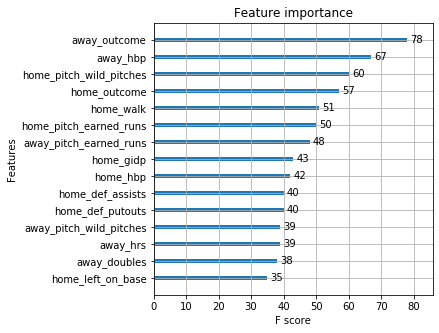

In [92]:
xgb.plot_importance(xg_cutt,max_num_features = 15)
plt.rcParams['figure.figsize'] = [5, 5]
plt.show()

## Gaussian

In [83]:
gnb = GaussianNB()
gnb.fit(X_train,y_train)
pred_gnb = gnb.predict(X_train)
score_gnb = accuracy_score(y_train,pred_gnb)
print(score_gnb)

0.5530943807051336


## Voting Classifier

In [109]:
clf1 = LogisticRegression(C=0.05,penalty='l2',max_iter=1000)
clf2 = xgb.XGBClassifier()
clf3 = DecisionTreeClassifier()
eclf = VotingClassifier(estimators=[('lr',clf1),('xg',clf2),('dt',clf3)],
                        voting='hard')
eclf.fit(X_train,y_train)
eclf_preds = eclf.predict(X_train)
eclf_score = accuracy_score(y_train,eclf_preds)
print(eclf_score)

eclf_preds_test = eclf.predict(X_test)
eclf_score_test = accuracy_score(y_test,eclf_preds_test)
print(eclf_score_test)

0.6631354157943221
0.5662605200351715
